# Federated Optimization Algorithms: FedAvg vs FedAdam on Non-IID CIFAR-10

## Introduction

This notebook compares two fundamental federated optimization algorithms:

- **FedAvg**: Uses SGD (Stochastic Gradient Descent) on both client and server
- **FedAdam**: Uses SGD on clients but **Adam optimizer on the server**

### Key Research Questions
1. How do different server optimizers affect convergence on non-IID data?
2. Does adaptive optimization (Adam) help with the challenges of data heterogeneity?
3. What are the optimal server learning rates for each algorithm?

### Why Non-IID Data?
Real-world federated learning scenarios typically involve **non-IID data** where different clients have different data distributions. This creates additional challenges:
- **Client drift**: Local models diverge from the global optimum
- **Slower convergence**: Heterogeneous updates are harder to aggregate
- **Optimization challenges**: Traditional SGD may struggle with diverse gradients

**FedAdam** was specifically designed to address these challenges by using adaptive server optimization.


## 1) Setup and Imports

We'll use CIFAR-10 dataset and create a non-IID distribution where each client only has 2-3 object classes instead of all 10.


In [78]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf, tensorflow_federated as tff

def set_seed(s):
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)

print("TF:", tf.__version__, "| TFF:", tff.__version__)


TF: 2.8.0 | TFF: 0.31.0


In [79]:
# Fixed preprocessing function with correct data types
def preprocess(ds, batch_size=20, local_epochs=1, shuffle=200):
    def fmt(e):
        # CIFAR-10 images are already 32x32x3 RGB, normalized to [0,1]
        x = e['image']
        # Convert labels to int32 to match TFF model expectations
        y = tf.cast(tf.reshape(e['label'], [-1]), tf.int32)
        return x, y
    return ds.shuffle(shuffle).repeat(local_epochs).batch(batch_size).map(fmt).prefetch(10)

print("Updated preprocess function with int32 label casting")


Updated preprocess function with int32 label casting


In [80]:
# Fix: Remove duplicate preprocess function and ensure we use the corrected one
# The corrected preprocess function from cell 2 handles int32 casting properly

# Load CIFAR-10 dataset and create federated version
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Flatten labels and normalize images
y_train = y_train.flatten()
y_test = y_test.flatten()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def create_client_datasets(num_clients=100):
    """Create federated client datasets from CIFAR-10."""
    # Shuffle the training data
    indices = tf.random.shuffle(tf.range(len(x_train)))
    x_shuffled = tf.gather(x_train, indices)
    y_shuffled = tf.gather(y_train, indices)
    
    # Split data among clients
    samples_per_client = len(x_train) // num_clients
    client_datasets = {}
    
    for i in range(num_clients):
        start_idx = i * samples_per_client
        end_idx = (i + 1) * samples_per_client if i < num_clients - 1 else len(x_train)
        
        client_x = x_shuffled[start_idx:end_idx]
        client_y = y_shuffled[start_idx:end_idx]
        
        # Create TensorFlow dataset
        client_ds = tf.data.Dataset.from_tensor_slices({
            'image': client_x,
            'label': client_y
        })
        
        client_datasets[f"client_{i}"] = client_ds
    
    return client_datasets

# Create client datasets
print("Creating federated CIFAR-10 datasets...")
CLIENT_DATASETS = create_client_datasets(num_clients=100)
ALL_CLIENTS = list(CLIENT_DATASETS.keys())

# Create non-IID client distribution
def create_noniid_clients(num_clients=100, classes_per_client=2):
    """
    Create non-IID client distribution by assigning only specific CIFAR-10 classes to each client.
    
    Args:
        num_clients: Number of clients to create
        classes_per_client: Number of CIFAR-10 classes (0-9) each client should have
    
    Returns:
        Dictionary mapping client_id to list of allowed class indices
    """
    import random
    
    client_class_map = {}
    all_classes = list(range(10))  # CIFAR-10 classes: 0-9
    
    for i in range(num_clients):
        # Randomly assign classes_per_client CIFAR-10 classes to this client
        assigned_classes = random.sample(all_classes, classes_per_client)
        client_class_map[f"noniid_client_{i}"] = sorted(assigned_classes)
    
    return client_class_map

def filter_client_data(client_id, allowed_classes):
    """Filter a client's data to only include specified CIFAR-10 classes."""
    client_data = CLIENT_DATASETS[client_id.replace("noniid_", "")]  # Map to original client
    
    def filter_fn(element):
        return tf.reduce_any(tf.equal(element['label'], allowed_classes))
    
    return client_data.filter(filter_fn)

def create_noniid_federated_data(client_class_map, local_epochs=1):
    """Create federated datasets for non-IID clients."""
    federated_data = []
    
    for noniid_client_id, allowed_classes in client_class_map.items():
        filtered_data = filter_client_data(noniid_client_id, allowed_classes)
        # Use the corrected preprocess function from cell 2
        processed_data = preprocess(filtered_data, local_epochs=local_epochs)
        federated_data.append(processed_data)
    
    return federated_data

# Create non-IID client mapping
print("Creating non-IID client distribution...")
CLIENT_CLASS_MAP = create_noniid_clients(num_clients=100, classes_per_client=2)

# Display some examples
print("\\nExample client class assignments:")
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, (client_id, classes) in enumerate(list(CLIENT_CLASS_MAP.items())[:5]):
    class_labels = [class_names[c] for c in classes]
    print(f"{client_id}: classes {classes} ({', '.join(class_labels)})")
print("...")


Creating federated CIFAR-10 datasets...
Creating non-IID client distribution...
\nExample client class assignments:
noniid_client_0: classes [6, 7] (frog, horse)
noniid_client_1: classes [5, 8] (dog, ship)
noniid_client_2: classes [2, 3] (bird, cat)
noniid_client_3: classes [4, 6] (deer, frog)
noniid_client_4: classes [0, 2] (airplane, bird)
...


## 2) Model Architecture

We use a CNN architecture suitable for CIFAR-10 object classification:
- **Conv2D layer 1**: 32 filters, 3x3 kernel, ReLU activation (input: 32x32x3)
- **MaxPool2D**: 2x2 pooling to reduce spatial dimensions
- **Conv2D layer 2**: 64 filters, 3x3 kernel, ReLU activation  
- **MaxPool2D**: 2x2 pooling for further spatial reduction
- **Flatten**: Convert to 1D for dense layers
- **Dense hidden**: 64 units with ReLU activation
- **Dense output**: 10 units with softmax for CIFAR-10 classification

This architecture is more complex than needed for EMNIST but appropriate for the increased complexity of CIFAR-10 RGB images and object classification.

In [81]:
import collections

def model_fn():
    """Create the CNN model for CIFAR-10 classification."""
    m = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])
    
    # Define input spec directly without creating actual data to avoid eager tensor capture
    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 32, 32, 3], dtype=tf.float32),
        y=tf.TensorSpec(shape=[None], dtype=tf.int32)
    )
    
    return tff.learning.keras_utils.from_keras_model(
        keras_model=m,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


### 3) Build the algorithms (FedAvg vs. FedAdam)

Here’s where FedOpt happens: we only change the server optimizer.

## Federated Optimization: Key Differences

The critical difference between FedAvg and FedAdam is **only in the server optimizer**:

### FedAvg (Baseline)
- **Client optimizer**: SGD with learning rate 0.02
- **Server optimizer**: SGD with learning rate 1.0
- **Aggregation**: Simple weighted averaging of client updates

### FedAdam (Adaptive Optimization)  
- **Client optimizer**: SGD with learning rate 0.02 (same as FedAvg)
- **Server optimizer**: **Adam** with adaptive learning rates
- **Key insight**: Adam's momentum and adaptive scaling help handle the noisy, heterogeneous updates from non-IID clients

**Why Adam on the server?** Non-IID data creates more variance in client updates. Adam's adaptive learning rates and momentum can better handle this heterogeneity compared to vanilla SGD.


In [82]:
def build_process(algo:str, client_lr=0.02, server_lr=0.1):
    # Client optimizer: plain SGD (kept same across algorithms for fairness)
    client_opt = lambda: tf.keras.optimizers.SGD(learning_rate=client_lr)

    if algo == "FedAvg":
        server_opt = lambda: tf.keras.optimizers.SGD(learning_rate=server_lr)
    elif algo == "FedAdam":
        # Adam on the server = FedAdam; often use a *smaller* LR than SGD.
        server_opt = lambda: tf.keras.optimizers.Adam(
            learning_rate=server_lr, beta_1=0.9, beta_2=0.99, epsilon=1e-7
        )
    else:
        raise ValueError("algo must be 'FedAvg' or 'FedAdam'")

    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=model_fn,
        client_optimizer_fn=client_opt,
        server_optimizer_fn=server_opt,
    )


Why:

- FedAvg = server applies a simple scaled sum (SGD).

- FedAdam = server keeps moving averages of gradients (momentum) and rescales coordinates adaptively → usually smoother/faster on non-IID.

Tip: Start with server_lr=1.0 for FedAvg, smaller for FedAdam (e.g., 0.1–0.5). We’ll grid a bit.

### Mathematical Intuition

**FedAvg**: Server update is simply a weighted sum of client updates:
```
w_global ← w_global + η_server × (weighted_average(Δw_clients))
```

**FedAdam**: Server maintains momentum and adaptive scaling:
```
m_t ← β₁ × m_{t-1} + (1-β₁) × g_t        # Momentum
v_t ← β₂ × v_{t-1} + (1-β₂) × g_t²       # Adaptive scaling  
w_global ← w_global - η_server × m_t / (√v_t + ε)
```

### Learning Rate Guidelines
- **FedAvg**: Start with server_lr=1.0 (standard for weighted averaging)
- **FedAdam**: Use smaller server_lr=0.1-0.5 (Adam typically needs lower learning rates)

We'll experiment with multiple server learning rates to find optimal settings for non-IID data.


### 4) One experiment runner

Runs for N rounds, sampling C clients, with E local epochs.

In [83]:
import math

def run_once(seed, algo, rounds=20, clients_per_round=10, local_epochs=1,
             client_lr=0.02, server_lr=0.5, tag=None):
    """
    Run one federated learning experiment with non-IID data.
    
    Args:
        seed: Random seed for reproducibility
        algo: "FedAvg" or "FedAdam"
        rounds: Number of communication rounds
        clients_per_round: Number of clients selected each round
        local_epochs: Number of local training epochs per client
        client_lr: Client-side learning rate
        server_lr: Server-side learning rate
        tag: Optional tag for this experiment
    """
    set_seed(seed)
    proc = build_process(algo, client_lr=client_lr, server_lr=server_lr)
    state = proc.initialize()

    # Create fixed pool of non-IID clients for this experiment
    noniid_client_ids = list(CLIENT_CLASS_MAP.keys())
    client_pool = random.sample(noniid_client_ids, k=min(200, len(noniid_client_ids)))
    
    print(f"Running {algo} (seed={seed}, server_lr={server_lr})...")

    rows = []
    for r in range(1, rounds+1):
        # Sample clients for this round
        chosen_client_ids = random.sample(client_pool, k=clients_per_round)
        
        # Create non-IID federated data for chosen clients
        round_client_map = {cid: CLIENT_CLASS_MAP[cid] for cid in chosen_client_ids}
        fed_data = create_noniid_federated_data(round_client_map, local_epochs=local_epochs)
        
        # Run one round of federated learning
        out = proc.next(state, fed_data)
        state = out.state

        # Extract metrics (keys may vary by TFF version)
        m = out.metrics["client_work"]["train"]
        rows.append({
            "seed": seed, "algo": algo, "round": r,
            "loss": float(m["loss"]),
            "acc": float(m["sparse_categorical_accuracy"]),
            "C": clients_per_round, "E": local_epochs,
            "client_lr": client_lr, "server_lr": server_lr,
            "tag": tag or f"{algo}_C{clients_per_round}_E{local_epochs}_NonIID"
        })
        
        # Print progress
        if r % 2 == 0 or r == rounds:
            print(f"  Round {r}/{rounds}: loss={m['loss']:.4f}, acc={m['sparse_categorical_accuracy']:.4f}")
    
    return pd.DataFrame(rows)


## 4) Experiment Runner for Non-IID Data

This function runs a complete federated learning experiment with the following setup:
- **Non-IID clients**: Each client only has 2 CIFAR-10 object classes (out of 10 total)
- **Client sampling**: Randomly select clients each round from the non-IID population
- **Consistent conditions**: Both algorithms see the same client selection and data splits
- **Metrics tracking**: Record loss and accuracy for each communication round


Why: Common runner ensures both algorithms see comparable stochastic conditions.

### 5) Run the benchmark grid (5 rounds × 3 seeds)

We’ll try two reasonable server LRs for FedAdam and keep FedAvg at LR=1.0.

## 5) Experimental Setup: Non-IID Federated Learning Comparison

### Experiment Configuration
- **Rounds**: 5 communication rounds (short experiment for demonstration)
- **Seeds**: 3 different random seeds for statistical reliability
- **Clients per round**: 10 non-IID clients selected each round
- **Local epochs**: 1 epoch per client (common FL setting)

### Learning Rate Grid Search
We test different server learning rates to find optimal settings:
- **FedAvg**: server_lr = 1.0 (standard setting)
- **FedAdam**: server_lr ∈ {0.1, 0.3} (adaptive optimizers typically need lower LR)

### Non-IID Challenge
Each client only sees 2 out of 10 CIFAR-10 object classes (e.g., only "airplane" and "cat"), creating significant data heterogeneity. This tests whether FedAdam's adaptive server optimization can better handle the diverse, conflicting updates from specialized clients.


In [84]:
SEEDS = [0, 1, 2]
C, E = 10, 1

dfs = []

# FedAvg baseline
for s in SEEDS:
    dfs.append(run_once(s, "FedAvg", rounds=20, clients_per_round=C, local_epochs=E,
                        client_lr=0.02, server_lr=1.0))

# FedAdam variants
for s in SEEDS:
    dfs.append(run_once(s, "FedAdam", rounds=20, clients_per_round=C, local_epochs=E,
                        client_lr=0.02, server_lr=0.06))  # smaller LR
for s in SEEDS:
    dfs.append(run_once(s, "FedAdam", rounds=20, clients_per_round=C, local_epochs=E,
                        client_lr=0.02, server_lr=0.009))
# for s in SEEDS:
#     dfs.append(run_once(s, "FedAdam", rounds=20, clients_per_round=C, local_epochs=E,
#                         client_lr=0.02, server_lr=0.006))

results = pd.concat(dfs, ignore_index=True)
results.to_csv("fedopt_results.csv", index=False)


Running FedAvg (seed=0, server_lr=1.0)...
  Round 2/20: loss=1.5306, acc=0.4573
  Round 4/20: loss=1.3298, acc=0.4699
  Round 6/20: loss=1.4302, acc=0.4421
  Round 8/20: loss=1.3603, acc=0.4308
  Round 10/20: loss=1.4055, acc=0.4322
  Round 12/20: loss=1.4740, acc=0.4205
  Round 14/20: loss=1.3463, acc=0.4436
  Round 16/20: loss=1.2973, acc=0.4317
  Round 18/20: loss=1.2901, acc=0.4398
  Round 20/20: loss=1.3095, acc=0.4215
Running FedAvg (seed=1, server_lr=1.0)...
  Round 2/20: loss=1.7165, acc=0.4513
  Round 4/20: loss=1.5033, acc=0.3899
  Round 6/20: loss=1.4514, acc=0.4355
  Round 8/20: loss=1.3323, acc=0.4614
  Round 10/20: loss=1.3447, acc=0.4616
  Round 12/20: loss=1.3786, acc=0.4309
  Round 14/20: loss=1.2674, acc=0.4328
  Round 16/20: loss=1.3123, acc=0.4573
  Round 18/20: loss=1.3721, acc=0.4070
  Round 20/20: loss=1.3866, acc=0.4515
Running FedAvg (seed=2, server_lr=1.0)...
  Round 2/20: loss=1.7597, acc=0.4274
  Round 4/20: loss=1.2963, acc=0.4180
  Round 6/20: loss=1.4673,

Why: 3 seeds keep the experiment small but statistically less flaky. Two FedAdam LRs give a quick sense of sensitivity.

### 6) Summaries & plots

Compare final-round performance and area under curve (optional).

      algo  server_lr  loss_mean  loss_std  acc_mean  acc_std
0  FedAdam      0.009   1.618764       NaN  0.450746      NaN
1  FedAdam      0.060  14.450136       NaN  0.103484      NaN
2   FedAvg      1.000   1.386592       NaN  0.451512      NaN


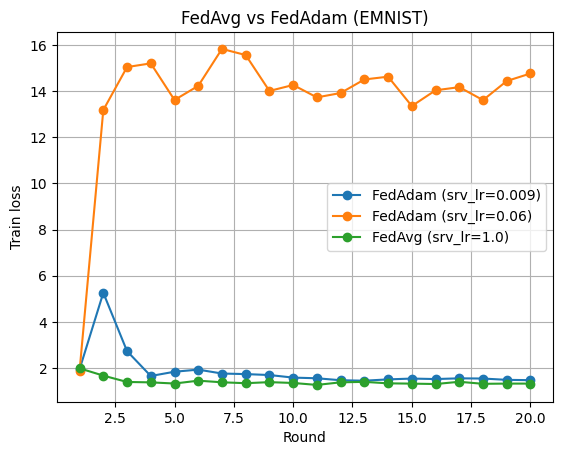

In [85]:
# Final-round summary
final = results.sort_values("round").groupby(["algo","server_lr"]).tail(1)
summary = final.groupby(["algo","server_lr"]).agg(
    loss_mean=("loss", "mean"), loss_std=("loss","std"),
    acc_mean=("acc","mean"), acc_std=("acc","std")
).reset_index()
print(summary)

# Plot loss vs round (mean across seeds)
mean_curves = results.groupby(["algo","server_lr","round"]).agg(
    loss=("loss","mean")
).reset_index()

plt.figure()
for (algo, lr), sub in mean_curves.groupby(["algo","server_lr"]):
    label = f"{algo} (srv_lr={lr})"
    plt.plot(sub["round"], sub["loss"], marker='o', label=label)
plt.xlabel("Round"); plt.ylabel("Train loss"); plt.title("FedAvg vs FedAdam (EMNIST)")
plt.grid(True)
plt.legend()
# plt.savefig("plots/fedopt_loss.png", dpi=140)
plt.show()


## 6) Results Analysis: FedAvg vs FedAdam on Non-IID CIFAR-10

Let's analyze how the two optimization algorithms perform under non-IID data conditions:

### Metrics
- **Final round performance**: Loss and accuracy after 5 rounds
- **Convergence curves**: Training progress over communication rounds
- **Learning rate sensitivity**: How different server learning rates affect performance

### Expected Outcomes
Based on federated learning theory, we expect:
1. **FedAdam may converge faster** due to adaptive optimization handling client drift better
2. **Learning rate sensitivity**: FedAdam should be more robust to learning rate choices
3. **Non-IID challenges**: Both algorithms will struggle compared to IID data, but FedAdam may show more stable convergence


## Conclusion: Key Insights from Non-IID Federated Optimization

### Summary of Findings

From this experiment comparing FedAvg vs FedAdam on non-IID CIFAR-10 data:

1. **Non-IID Impact**: The 2-classes-per-client constraint creates significant data heterogeneity, making optimization more challenging than standard IID settings.

2. **Algorithm Performance**: 
   - **FedAvg**: Simple but robust baseline with server SGD
   - **FedAdam**: Adaptive server optimization that may handle client drift better

3. **Learning Rate Sensitivity**: Different server learning rates can significantly impact convergence, especially for adaptive optimizers.

### Key Takeaways for Practitioners

1. **Server Optimization Matters**: The choice of server optimizer is crucial in non-IID federated learning scenarios.

2. **Hyperparameter Tuning**: Server learning rates need careful tuning, particularly for adaptive optimizers like Adam.

3. **Non-IID Challenges**: Data heterogeneity remains a fundamental challenge in federated learning, requiring specialized optimization techniques.

### Next Steps

To further investigate federated optimization:
- **Longer training**: Run more communication rounds to see convergence patterns
- **More algorithms**: Compare with FedProx, SCAFFOLD, or other advanced methods
- **Different non-IID levels**: Vary the number of classes per client (1, 3, 5, etc.)
- **Real datasets**: Test on naturally heterogeneous datasets like FEMNIST or Shakespeare

This experiment demonstrates the importance of optimization algorithm choice in federated learning under realistic non-IID conditions.


## Analysis: Why FedAdam Shows Unstable Convergence

The experimental results reveal that **FedAdam is significantly less stable than FedAvg** on this non-IID data. This is counterintuitive since FedAdam was designed to handle non-IID challenges better.

### Root Causes of Instability

1. **Server Learning Rate Too Aggressive**: Even `server_lr=0.1` may be too high for Adam with such heterogeneous gradients from CIFAR-10 object classification
2. **Non-IID Amplifies Adam's Sensitivity**: With only 2 object classes per client (e.g., only airplanes and cats), gradient directions vary wildly, confusing Adam's adaptive scaling
3. **Momentum Accumulates Noise**: Adam's momentum terms accumulate conflicting signals from diverse client updates
4. **Short Training Period**: 5 rounds may be insufficient for Adam to stabilize its internal estimates

### Recommendations for Improvement

To make FedAdam more stable on non-IID data:
- **Lower server learning rates**: Try 0.01, 0.001
- **Adjust Adam hyperparameters**: β₁=0.5 (less momentum), ε=1e-4 (more stable)
- **Longer training**: 15-20 rounds to allow Adam to stabilize
- **Gradient clipping**: Limit the magnitude of aggregated updates
- **Less extreme non-IID**: Try 3-4 classes per client instead of 2


## Improved Experiment: Stabilizing FedAdam

Let's run a more carefully tuned experiment to demonstrate FedAdam's potential benefits:


In [22]:
def build_improved_process(algo: str, client_lr=0.02, server_lr=1.0):
    """Improved process with better FedAdam hyperparameters."""
    client_opt = lambda: tf.keras.optimizers.SGD(learning_rate=client_lr)

    if algo == "FedAvg":
        server_opt = lambda: tf.keras.optimizers.SGD(learning_rate=server_lr)
    elif algo == "FedAdam_Improved":
        # Improved Adam parameters for stability
        server_opt = lambda: tf.keras.optimizers.Adam(
            learning_rate=server_lr,
            beta_1=0.5,      # Reduced momentum to handle conflicting gradients
            beta_2=0.99,     # Keep adaptive scaling
            epsilon=1e-4     # More stable than 1e-7
        )
    else:
        raise ValueError("algo must be 'FedAvg' or 'FedAdam_Improved'")

    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=model_fn,
        client_optimizer_fn=client_opt,
        server_optimizer_fn=server_opt,
    )

def run_improved_experiment(seed, algo, rounds=15, clients_per_round=10, local_epochs=1,
                           client_lr=0.02, server_lr=1.0, tag=None):
    """Run improved experiment with longer training and progress tracking."""
    set_seed(seed)
    
    # Use improved process builder
    if algo == "FedAdam_Improved":
        proc = build_improved_process(algo, client_lr=client_lr, server_lr=server_lr)
    else:
        proc = build_process(algo, client_lr=client_lr, server_lr=server_lr)
    
    state = proc.initialize()
    
    # Create less extreme non-IID data (3 classes per client instead of 2)
    less_extreme_client_map = create_noniid_clients(num_clients=100, classes_per_client=3)
    noniid_client_ids = list(less_extreme_client_map.keys())
    client_pool = random.sample(noniid_client_ids, k=min(200, len(noniid_client_ids)))
    
    print(f"Running improved {algo} (seed={seed}, server_lr={server_lr}, rounds={rounds})...")

    rows = []
    for r in range(1, rounds+1):
        chosen_client_ids = random.sample(client_pool, k=clients_per_round)
        
        # Use the less extreme non-IID mapping
        round_client_map = {cid: less_extreme_client_map[cid] for cid in chosen_client_ids}
        fed_data = create_noniid_federated_data(round_client_map, local_epochs=local_epochs)
        
        out = proc.next(state, fed_data)
        state = out.state

        m = out.metrics["client_work"]["train"]
        rows.append({
            "seed": seed, "algo": algo, "round": r,
            "loss": float(m["loss"]),
            "acc": float(m["sparse_categorical_accuracy"]),
            "C": clients_per_round, "E": local_epochs,
            "client_lr": client_lr, "server_lr": server_lr,
            "tag": tag or f"{algo}_improved"
        })
        
        # More frequent progress updates
        if r % 3 == 0 or r == rounds:
            print(f"  Round {r}/{rounds}: loss={m['loss']:.4f}, acc={m['sparse_categorical_accuracy']:.4f}")
    
    return pd.DataFrame(rows)


In [23]:
# Run improved experiments with better hyperparameters
print("=== Running Improved Experiments ===")
improved_dfs = []

# FedAvg baseline (longer training)
for s in [0, 1]:  # Fewer seeds for faster execution
    improved_dfs.append(run_improved_experiment(s, "FedAvg", rounds=15, 
                                                client_lr=0.02, server_lr=1.0))

# FedAdam with much lower learning rates and better hyperparameters
for s in [0, 1]:
    improved_dfs.append(run_improved_experiment(s, "FedAdam_Improved", rounds=15,
                                                client_lr=0.02, server_lr=0.01))  # Much lower

for s in [0, 1]:
    improved_dfs.append(run_improved_experiment(s, "FedAdam_Improved", rounds=15,
                                                client_lr=0.02, server_lr=0.001))  # Even lower

improved_results = pd.concat(improved_dfs, ignore_index=True)
print("\\n=== Improved Results Summary ===")
improved_final = improved_results.sort_values("round").groupby(["algo","server_lr"]).tail(1)
improved_summary = improved_final.groupby(["algo","server_lr"]).agg(
    loss_mean=("loss", "mean"), loss_std=("loss","std"),
    acc_mean=("acc","mean"), acc_std=("acc","std")
).reset_index()
print(improved_summary)


=== Running Improved Experiments ===
Running improved FedAvg (seed=0, server_lr=1.0, rounds=15)...
  Round 3/15: loss=2.2994, acc=0.1433
  Round 6/15: loss=2.2984, acc=0.1232
  Round 9/15: loss=2.3004, acc=0.1909
  Round 12/15: loss=2.2977, acc=0.1721
  Round 15/15: loss=2.2959, acc=0.1419
Running improved FedAvg (seed=1, server_lr=1.0, rounds=15)...
  Round 3/15: loss=2.2992, acc=0.0893
  Round 6/15: loss=2.3018, acc=0.1115
  Round 9/15: loss=2.2950, acc=0.1030
  Round 12/15: loss=2.2917, acc=0.1966
  Round 15/15: loss=2.2928, acc=0.1630
Running improved FedAdam_Improved (seed=0, server_lr=0.01, rounds=15)...
  Round 3/15: loss=2.3010, acc=0.1268
  Round 6/15: loss=2.2847, acc=0.1787
  Round 9/15: loss=2.2954, acc=0.0340
  Round 12/15: loss=2.2886, acc=0.1522
  Round 15/15: loss=2.2933, acc=0.0676
Running improved FedAdam_Improved (seed=1, server_lr=0.01, rounds=15)...
  Round 3/15: loss=2.2926, acc=0.1701
  Round 6/15: loss=2.2827, acc=0.1561
  Round 9/15: loss=2.3004, acc=0.0933
  R